In [95]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shutil

# Paths
image_dir = '../256x256'
metadata_file = 'project-root/data/BCC_labels.csv'
output_dir = 'organized_data'

In [56]:
# Step 1: Load and process metadata
metadata = pd.read_csv(metadata_file)
metadata['label'] = metadata['label'].map({'Clear': 0, 'Present': 1})  # Map labels to 0 and 1

# Group by StudyID to split data
grouped = metadata.groupby('StudyID #')

In [57]:
slide_counts = {}
for slide_id in metadata['slide_id'].unique():
    slide_folder = os.path.join(image_dir, slide_id)
    if os.path.exists(slide_folder):
        slide_counts[slide_id] = len([f for f in os.listdir(slide_folder) if f.endswith('.png')])
    else:
        slide_counts[slide_id] = 0

print(f"Tissue images per slide: {slide_counts}")
print(f"Total tissue images found: {sum(slide_counts.values())}")

Tissue images per slide: {'slide-2022-02-09T12-26-27-R5-S1': 3, 'slide-2022-02-09T12-28-49-R5-S2': 3, 'slide-2022-02-09T12-30-52-R5-S3': 2, 'slide-2022-02-09T12-33-12-R5-S4': 2, 'slide-2022-02-09T12-36-31-R5-S5': 1, 'slide-2022-02-09T12-38-53-R5-S6': 2, 'slide-2022-02-09T12-41-58-R5-S7': 1, 'slide-2022-02-09T12-44-19-R5-S8': 2, 'slide-2022-02-09T12-47-21-R5-S9': 4, 'slide-2022-02-09T13-08-40-R5-S17': 2, 'slide-2022-02-09T13-11-39-R5-S18': 2, 'slide-2022-02-09T13-14-10-R5-S19': 2, 'slide-2022-02-09T13-15-57-R5-S20': 3, 'slide-2022-02-09T13-18-39-R5-S21': 4, 'slide-2022-02-09T13-21-07-R5-S22': 3, 'slide-2022-02-09T13-23-51-R5-S23': 2, 'slide-2022-02-09T13-26-16-R5-S24': 2, 'slide-2022-02-09T13-29-07-R5-S25': 2, 'slide-2022-02-09T13-31-46-R6-S1': 2, 'slide-2022-02-09T13-33-41-R6-S2': 4, 'slide-2022-02-09T13-36-50-R6-S3': 2, 'slide-2022-02-09T13-39-43-R6-S4': 3, 'slide-2022-02-09T13-42-12-R6-S5': 3, 'slide-2022-02-09T13-44-36-R6-S6': 2, 'slide-2022-02-09T13-46-51-R6-S7': 5, 'slide-2022-02-

In [58]:
# Convert the keys to a list
train_study_ids, val_study_ids = train_test_split(list(grouped.groups.keys()), test_size=0.2, random_state=42)


# Create organized directories for training and validation sets
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

def organize_images(group_ids, dest_dir):
    total_copied = 0  # Track copied images
    for study_id in group_ids:
        group = grouped.get_group(study_id)
        for _, row in group.iterrows():
            slide_id = row['slide_id']
            label = row['label']
            label_dir = 'Clear' if label == 0 else 'Present'
            source_dir = os.path.join(image_dir, slide_id)
            dest_label_dir = os.path.join(dest_dir, label_dir)
            os.makedirs(dest_label_dir, exist_ok=True)
            if os.path.exists(source_dir):
                for file in os.listdir(source_dir):
                    if file.endswith('.png'):
                        # Append slide_id to filename to prevent overwriting
                        new_file_name = f"{slide_id}_{file}"
                        shutil.copy(
                            os.path.join(source_dir, file),
                            os.path.join(dest_label_dir, new_file_name)
                        )
                        total_copied += 1
    print(f"Total images copied to {dest_dir}: {total_copied}")

# Re-run the function with this updated code
organize_images(train_study_ids, train_dir)
organize_images(val_study_ids, val_dir)

Total images copied to organized_data/train: 165
Total images copied to organized_data/val: 43


In [91]:
# Step 2: ImageDataGenerator for training and validation
#image_size = (1792, 1792)
image_size = (256, 256)
batch_size = 32  # Adjust as per available memory

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
    channel_shift_range=0.1
)


val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 165 images belonging to 2 classes.
Found 43 images belonging to 2 classes.


In [109]:
# Step 3: Load the Pre-trained ResNet-50 model without the top layers
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1792, 1792, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)


predictions = Dense(1, activation='sigmoid')(x)

In [110]:
# Step 4: Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

In [111]:
# Step 5: Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [112]:
# Step 6: Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=1
)


Epoch 1/30
6/6 [==============================] - 5s 477ms/step - loss: 0.7326 - accuracy: 0.5091 - val_loss: 0.6965 - val_accuracy: 0.5116
Epoch 2/30
6/6 [==============================] - 2s 358ms/step - loss: 0.6912 - accuracy: 0.5515 - val_loss: 0.7603 - val_accuracy: 0.4884
Epoch 3/30
6/6 [==============================] - 2s 361ms/step - loss: 0.7222 - accuracy: 0.5152 - val_loss: 0.6897 - val_accuracy: 0.5349
Epoch 4/30
6/6 [==============================] - 2s 427ms/step - loss: 0.6950 - accuracy: 0.4848 - val_loss: 0.6903 - val_accuracy: 0.5116
Epoch 5/30
6/6 [==============================] - 2s 355ms/step - loss: 0.6936 - accuracy: 0.4606 - val_loss: 0.6890 - val_accuracy: 0.5581
Epoch 6/30
6/6 [==============================] - 2s 355ms/step - loss: 0.6873 - accuracy: 0.5455 - val_loss: 0.6893 - val_accuracy: 0.5116
Epoch 7/30
6/6 [==============================] - 2s 360ms/step - loss: 0.6936 - accuracy: 0.5030 - val_loss: 0.6848 - val_accuracy: 0.5116
Epoch 8/30
6/6 [====

In [116]:
# Fine-tuning phase with even lower learning rate
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(lr=5e-6), loss='binary_crossentropy', metrics=['accuracy'])  # Lowered fine-tune LR

history_fine_tune = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/40
6/6 [==============================] - 5s 478ms/step - loss: 0.3724 - accuracy: 0.8485 - val_loss: 0.4710 - val_accuracy: 0.8140
Epoch 2/40
6/6 [==============================] - 2s 356ms/step - loss: 0.3889 - accuracy: 0.8303 - val_loss: 0.4354 - val_accuracy: 0.8605
Epoch 3/40
6/6 [==============================] - 2s 352ms/step - loss: 0.3826 - accuracy: 0.8545 - val_loss: 0.4272 - val_accuracy: 0.8605
Epoch 4/40
6/6 [==============================] - 2s 357ms/step - loss: 0.3280 - accuracy: 0.8788 - val_loss: 0.4555 - val_accuracy: 0.8372
Epoch 5/40
6/6 [==============================] - 2s 362ms/step - loss: 0.3697 - accuracy: 0.8424 - val_loss: 0.4383 - val_accuracy: 0.8372
Epoch 6/40
6/6 [==============================] - 2s 356ms/step - loss: 0.3519 - accuracy: 0.8303 - val_loss: 0.4445 - val_accuracy: 0.8140
Epoch 7/40
6/6 [==============================] - 2s 357ms/step - loss: 0.3594 - accuracy: 0.8485 - val_loss: 0.4814 - val_accuracy: 0.8140
Epoch 8/40
6/6 [====

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


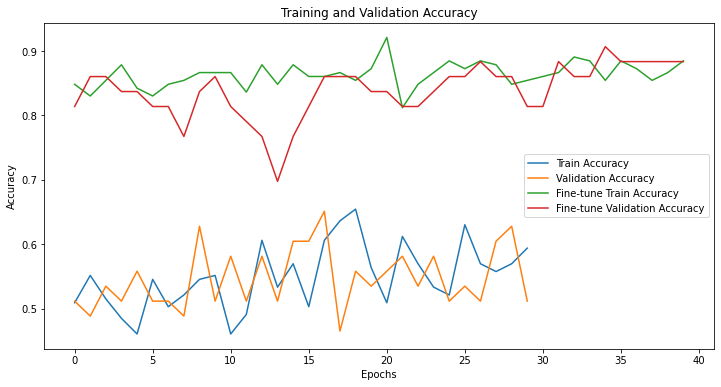

In [118]:
import matplotlib.pyplot as plt
# Save the model
model.save('bcc_model_basic.h5')

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine_tune.history['accuracy'], label='Fine-tune Train Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [119]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Step 1: Make predictions on the validation set
val_generator.reset()  # Ensure generator is at the start
predictions = model.predict(val_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to binary labels

# Step 2: Get true labels from the generator
true_classes = val_generator.classes

# Step 3: Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Step 4: Extract TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()  # Assuming a binary classification problem

# Display the results
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

# Optional: Print a classification report for additional metrics
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=val_generator.class_indices.keys()))


True Positives (TP): 15
True Negatives (TN): 13
False Positives (FP): 8
False Negatives (FN): 7

Classification Report:
              precision    recall  f1-score   support

       Clear       0.65      0.62      0.63        21
     Present       0.65      0.68      0.67        22

    accuracy                           0.65        43
   macro avg       0.65      0.65      0.65        43
weighted avg       0.65      0.65      0.65        43



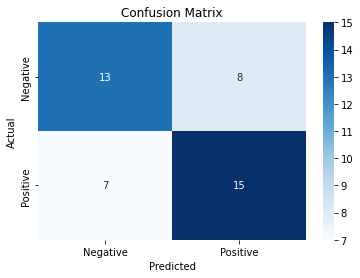

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
